In [1]:
%pylab inline
%matplotlib inline
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['/Users/Argen/Documents/MAS/R&D/Code/pgm'])

Populating the interactive namespace from numpy and matplotlib
Python 2.7.10 |Anaconda 2.3.0 (x86_64)| (default, May 28 2015, 17:04:42) 
[GCC 4.2.1 (Apple Inc. build 5577)] on darwin


In [2]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

In [3]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

In [4]:
import networkx as nx

In [5]:
from pgm.utils.tools import draw_graph, node_types
from pgm.nodes.chance import Chance
from pgm.nodes.decision import Decision
from pgm.nodes.utility import Utility

# Influence Diagram

## Definition

In [6]:
a = Chance('A')
b = Chance('B')
c = Chance('C')
d = Chance('D')
e = Chance('E')
f = Chance('F')
g = Chance('G')
h = Chance('H')
i = Chance('I')
j = Chance('J')
k = Chance('K')
l = Chance('L')

d1 = Decision('D1')
d2 = Decision('D2')
d3 = Decision('D3')
d4 = Decision('D4')

v1 = Utility('V1')
v2 = Utility('V2')
v3 = Utility('V3')
v4 = Utility('V4')

chance = [a, b, c, d, e, f, g, h, i, j, k, l]
decision = [d1, d2, d3, d4]
utility = [v1, v2, v3, v4]

edges = [(a, c), (b, c), (b, d1), (b, d), (d1, v1), (d1, d),
         (c, e), (d, e), (d, f), (e, g), (e, d2), (f, d2), (f, h),
         (g, d4), (g, i), (d2, i), (d2, d3), (h, k), (h, j), (d3, k), (d3, v2), (d3, d4),
         (d4, l), (i, l), (j, v3), (k, v3), (l, v4)]
nodes = []
nodes.extend(chance)
nodes.extend(decision)
nodes.extend(utility)

In [7]:
net = nx.DiGraph(title='influence_diagram')

id_nodes = [n.node for n in nodes]
id_edges = [(e[0].name, e[1].name) for e in edges]

net.add_nodes_from(id_nodes)
net.add_edges_from(id_edges, type='causal')

node_dict = node_types(net)
chance, decision, utility = node_dict.get('chance'), node_dict.get('decision'), node_dict.get('utility')

for n in net.nodes():
    ed = net.in_edges([n])
    if net.node[n]['type'] is 'chance':
        net.add_edges_from(ed, type='conditional')
    elif net.node[n]['type'] is 'decision':
        net.add_edges_from(ed, type='informational')
    elif net.node[n]['type'] is 'utility':
        net.add_edges_from(ed, type='functional')
#    'functional'
#    'conditional'
#    'informational'

# print net.nodes(data=True)
# print net.edges(data=True)

other


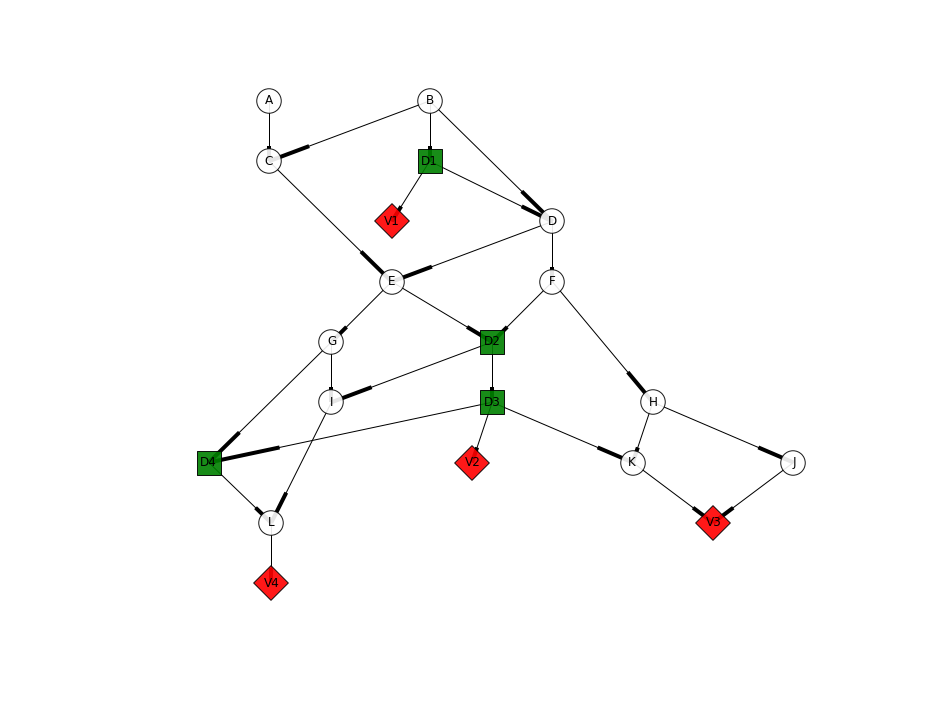

In [8]:
pos = nx.graphviz_layout(net, prog='dot')
draw_graph(net, pos)

### Validation

In [9]:
# TODO: Check cpt and ut size

def validate(graph, verbose=False):
        for n in graph.nodes():
            if verbose:
                print '----------'
                # print n
                # print 'Parents: ' + graph.predecessors(n).__str__()
                # print 'Children: ' + graph.successors(n).__str__()
                print '%s -> %s -> %s' %(graph.predecessors(n).__str__(), n, graph.successors(n).__str__())
                if not graph.is_directed():
                    print 'Neighbors: ' + graph.neighbors(n).__str__()
                print '----------'
                # print
        print 'ID is validated.'
        
validate(net, True)

----------
[] -> A -> ['C']
----------
----------
['A', 'B'] -> C -> ['E']
----------
----------
[] -> B -> ['C', 'D', 'D1']
----------
----------
['C', 'D'] -> E -> ['D2', 'G']
----------
----------
['B', 'D1'] -> D -> ['E', 'F']
----------
----------
['E'] -> G -> ['I', 'D4']
----------
----------
['D'] -> F -> ['H', 'D2']
----------
----------
['D2', 'G'] -> I -> ['L']
----------
----------
['F'] -> H -> ['K', 'J']
----------
----------
['H', 'D3'] -> K -> ['V3']
----------
----------
['H'] -> J -> ['V3']
----------
----------
['I', 'D4'] -> L -> ['V4']
----------
----------
['D1'] -> V1 -> []
----------
----------
['D3'] -> V2 -> []
----------
----------
['K', 'J'] -> V3 -> []
----------
----------
['L'] -> V4 -> []
----------
----------
['D3', 'G'] -> D4 -> ['L']
----------
----------
['E', 'F'] -> D2 -> ['I', 'D3']
----------
----------
['D2'] -> D3 -> ['D4', 'K', 'V2']
----------
----------
['B'] -> D1 -> ['V1', 'D']
----------
ID is validated.


## Partial Temporal Order

In [10]:
des = []
observed = []

windows = {}
order = {}


# Sort decision orders
for d in decision:
    pred = list(set(nx.ancestors(net, d)) & set(decision))
    des.insert(len(pred), d)
    n = len(pred) * 2
    parents = net.predecessors(d)
    observed.extend(parents)
    windows[n + 1] = [d]
    windows[n] = list(set(parents).difference(set(decision)))
    order[d] = n + 1
    order.update({p: n for p in parents})
n = max(order.values()) + 1
unobserved = list(set(chance).difference(observed))
order.update({u: n for u in unobserved})
windows.update({n: unobserved})
print 'Order: ', order
print 'Windows: ', windows

Order:  {'A': 8, 'C': 8, 'B': 0, 'E': 2, 'D': 8, 'G': 6, 'F': 2, 'I': 8, 'H': 8, 'K': 8, 'J': 8, 'L': 8, 'D4': 7, 'D2': 4, 'D3': 5, 'D1': 1}
Windows:  {0: ['B'], 1: ['D1'], 2: ['E', 'F'], 3: ['D2'], 4: [], 5: ['D3'], 6: ['G'], 7: ['D4'], 8: ['A', 'C', 'D', 'I', 'H', 'K', 'J', 'L']}


##### Function

In [11]:
order

{'A': 8,
 'B': 0,
 'C': 8,
 'D': 8,
 'D1': 1,
 'D2': 4,
 'D3': 5,
 'D4': 7,
 'E': 2,
 'F': 2,
 'G': 6,
 'H': 8,
 'I': 8,
 'J': 8,
 'K': 8,
 'L': 8}

### Moralize

In [12]:
def moralize(digraph, order):
    G = digraph.copy()
    G.graph['title']= 'moral_steps'
    
    nd = node_types(G)
    c, d, u = nd.get('chance'), nd.get('decision'), nd.get('utility')
    
    # Remove information links
    for n in d:
        for p in digraph.predecessors(n):
            G.remove_edge(p, n)
            
    # Add moral links
    moral_edges = []
    for n in digraph.nodes_iter():
        arcs = list(combinations(G.predecessors(n), 2))
        # print n, arcs
        for p1,p2 in arcs:
            if (p1, p2) in digraph.edges():
                G.add_edge(p1,p2,digraph.get_edge_data(p1,p2))
                # moral_edges.append(a)
            elif (p2,p1) in digraph.edges():
                G.add_edge(p2,p1,digraph.get_edge_data(p2,p1))
                # moral_edges.append(a[::-1])
            else:
                if order.get(p1) <= order.get(p2):
                    print p1, order.get(p1), p2, order.get(p2)
                    moral_edges.append((p1,p2))
                    #G.add_edge(p1,p2, type='moral')
                elif order.get(p1) > order.get(p2):
                    print p2, order.get(p2), p1, order.get(p1)
                    moral_edges.append((p2,p1))
                    # G.add_edge(p2,p1, type='moral')
                    
                
    #print moral_edges
    #G.add_edges_from(moral_edges, type='moral')
    #print G.edges()
    # Convert to undirected graph
    #moralgraph = G.to_undirected()
    moralgraph = nx.Graph(title='moral_graph', type='moral')
    moralgraph.add_nodes_from(G.nodes(data=True))
    moralgraph.add_edges_from(G.edges(data=True))
    moralgraph.add_edges_from(moral_edges, type='moral')
    #print moralgraph.edges()
    
    #moralgraph.graph['title']='moral_graph'
    #moralgraph.graph['type']='moral'
        
    # Remove utility nodes
    moralgraph.remove_nodes_from(utility)
    return moralgraph

B 0 A 8
C 8 D 8
D2 4 G 6
D3 5 H 8
D4 7 I 8
K 8 J 8
[('A', 'C'), ('A', 'B'), ('C', 'B'), ('C', 'E'), ('C', 'D'), ('B', 'D'), ('B', 'D1'), ('E', 'D'), ('E', 'G'), ('D', 'D1'), ('D', 'F'), ('G', 'I'), ('G', 'D2'), ('F', 'H'), ('I', 'D4'), ('I', 'D2'), ('I', 'L'), ('H', 'K'), ('H', 'J'), ('H', 'D3'), ('K', 'J'), ('K', 'D3'), ('L', 'D4')]
moral


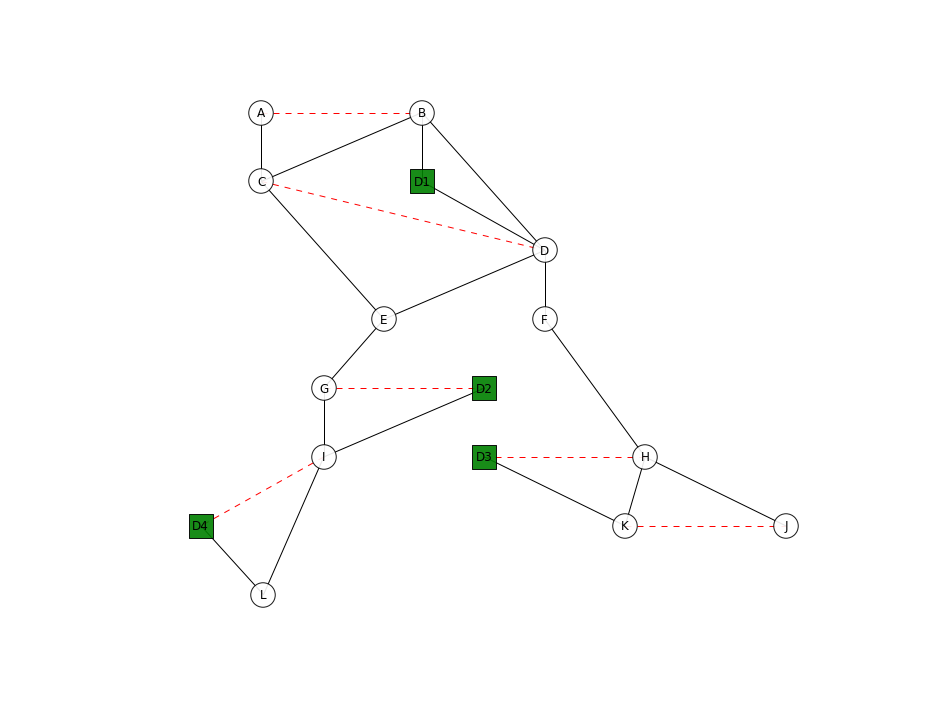

In [13]:
moral = moralize(net, order)
# print nx.get_edge_attributes(moral, 'type')
print moral.edges()
draw_graph(moral, pos)

### Evidence

### Triangulated Graph

In [14]:
def sp(x):
    return len(moral.node[x]['domain'])

def sz(V):
    s = 1
    for v in V:
        s = s * sp(v)
    return s

def fa(g, x, data=False):
    f = [x]
    if data:
        for n in g.neighbors(x[0]):
            f.append((n, g.node[n]))
        return f
    else:
        f.extend(g.neighbors(x))
        return f

def nb(g, x, data=False):
    neigh = []
    if data:
        for n in g.neighbors(x[0]):
            neigh.append((n, g.node[n]))
        return neigh
    else:
        return g.neighbors(x)

def is_simplicial(g, x):
    f = fa(g, x)
    n = nb(g, x)
    s = g.subgraph(f)
    if len(n)>1:
        t = []
        for e1, e2 in list(combinations(n, 2)):
            if g.has_edge(e1, e2) or g.has_edge(e2, e1):
                t.append(True)
            else:
                t.append(False)
        if sum(t) == len(t):
            return True
        else:
            return False
    else:
        return True



In [15]:
def triangulate(ugraph):
    t = ugraph.copy()
    fill_ins = []
    cliques = []
    
    for n, w in sorted(windows.items(), reverse=True):
        size = {}
        for i in w:
            size[i] = sz(fa(t, i))
    
        while size != {}:
            # Remove simplicial nodes
            simplicial = [n for n in size if is_simplicial(t, n)]
    
            if len(simplicial) > 0:
                for n in simplicial:
                    f = fa(t,n)
                    subset = filter(lambda x: set(f)< set(x), cliques)
                    if subset == []:
                        cliques.append(f)
                    t.remove_node(n)
                    size.pop(n)
            else:
                for i in size:
                    size[i] = sz(fa(t, i))
    
                if len(size) > 0:
                    candidate = min(size, key=size.get)
                    neigh = nb(t, candidate)
    
                    fill = []
                    # TODO: Algo esta mal con los cliques
                    for e1, e2 in list(combinations(neigh, 2)):
                        if not t.has_edge(e1, e2) or not t.has_edge(e2, e1):
                            t.add_edge(e1, e2)
                            fill_ins.append((e1, e2))
                            
                    f = fa(t,candidate)
                    subset = filter(lambda x: set(f)< set(x), cliques)
                    if subset == []:
                        cliques.append(f)
                    t.remove_node(candidate)
                    size.pop(candidate)
    
            # draw_graph(t, pos_ex)
    triangulated = ugraph.copy()
    triangulated.add_edges_from(fill_ins, type='triangulated')
    triangulated.graph['type']='triangulated'
    return triangulated

triangulated


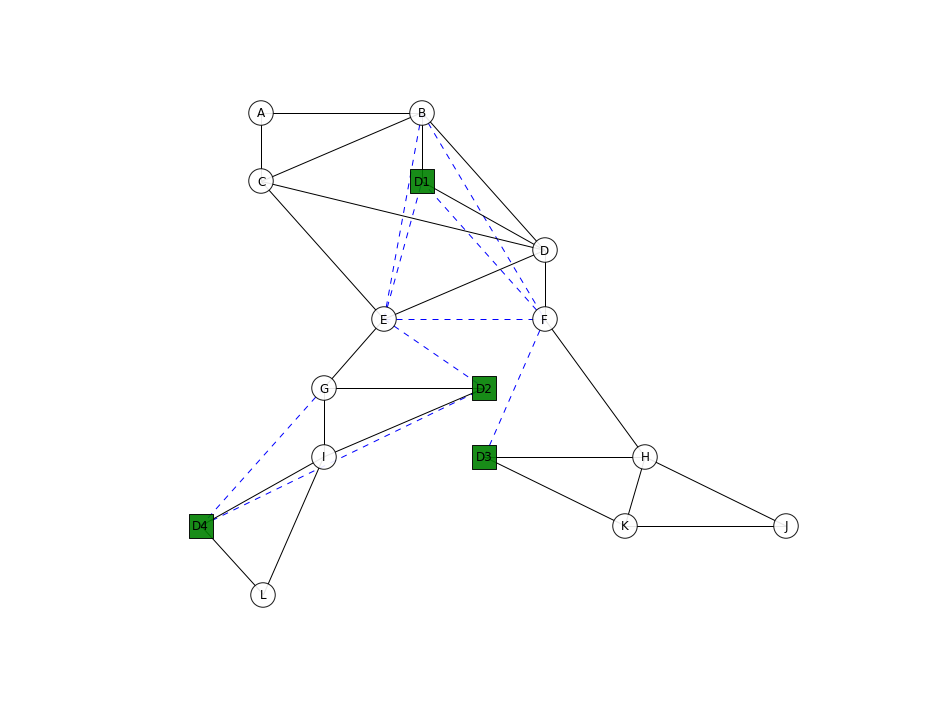

In [16]:
triangulated = triangulate(moral)
draw_graph(triangulated, pos)

triangulated


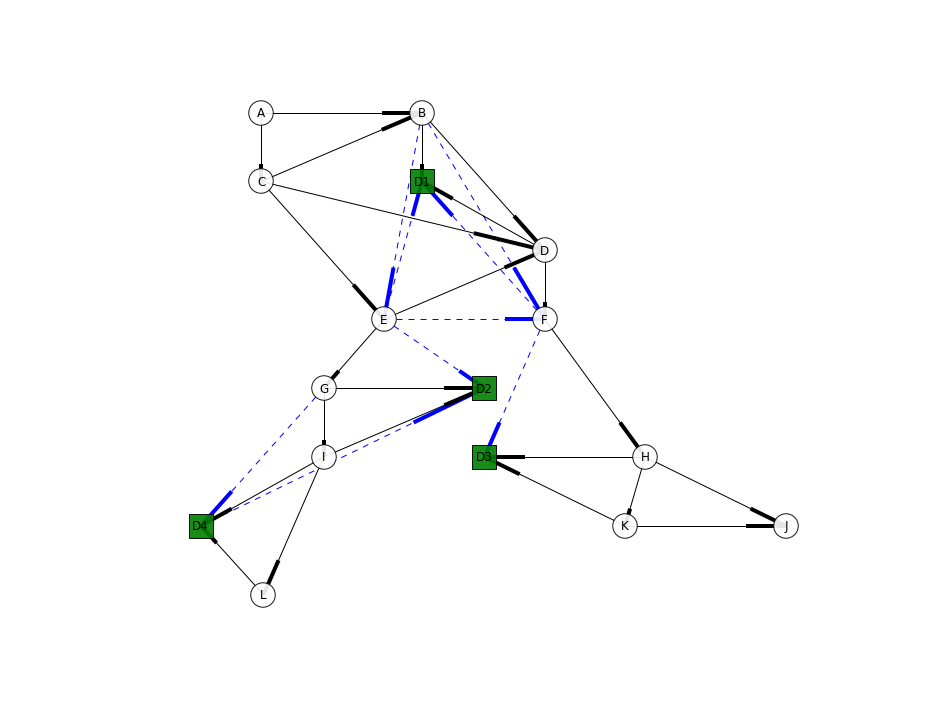

In [17]:
dir_chord_graph = nx.DiGraph(type='triangulated')
dir_chord_graph.add_nodes_from(triangulated.nodes(data=True))
dir_chord_graph.add_edges_from(triangulated.edges(data=True))


draw_graph(dir_chord_graph, pos)

### Junction Tree

In [18]:
def to_jointree(graph):
    G = graph.copy()
    cliques = [tuple(c) for c in nx.find_cliques(G)]
    edges = []
    for u, v in list(combinations(cliques, 2)):
        w = len(set(u).intersection(set(v)))
        if w >0:
            edges.append((u, v,-w))
    clique_graph = nx.Graph(title='clique_graph', type='clique')
    clique_graph.add_nodes_from(cliques)
    clique_graph.add_weighted_edges_from(edges)
    mst = nx.minimum_spanning_tree(clique_graph)

    join_tree = nx.Graph(name = '', type='join_tree')
    join_tree.add_nodes_from(mst.nodes(), type='clique')
    join_tree.add_edges_from(mst.edges())
    return join_tree

def to_junctiontree(graph):
    join_tree = to_jointree(graph) 
    junction_tree = nx.Graph(join_tree, type='junction_tree')

    for u, v in junction_tree.edges():
        junction_tree.add_edge(u, v, separator=tuple(set(u).intersection(set(v))), u_in=0, u_out=0, p_in=1, p_out=1)
    return junction_tree



join_tree


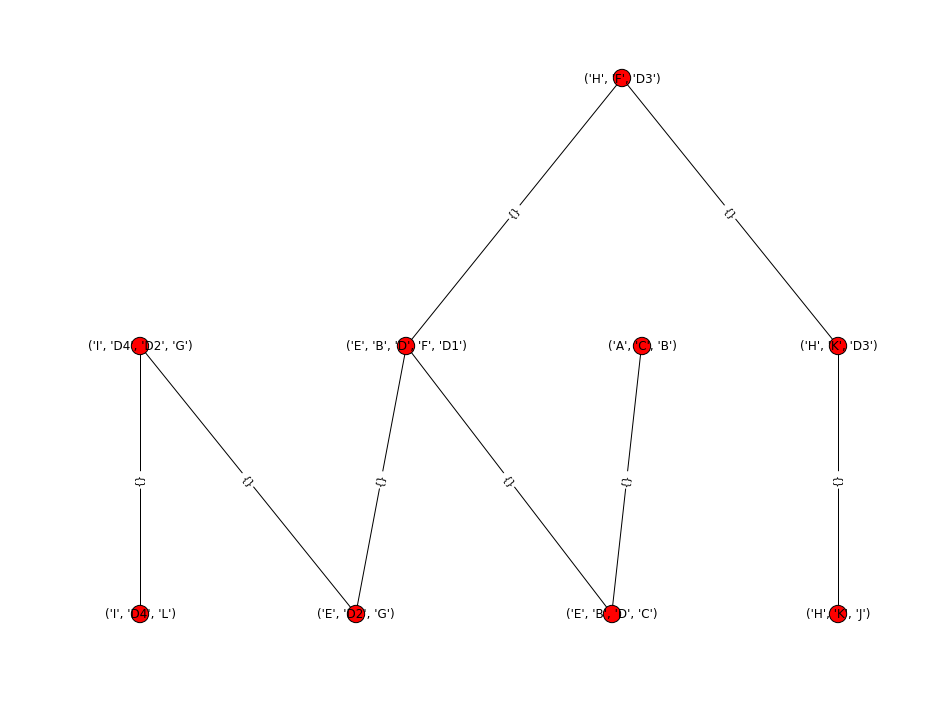

In [19]:
join_tree = to_jointree(triangulated)
draw_graph(join_tree)

junction_tree


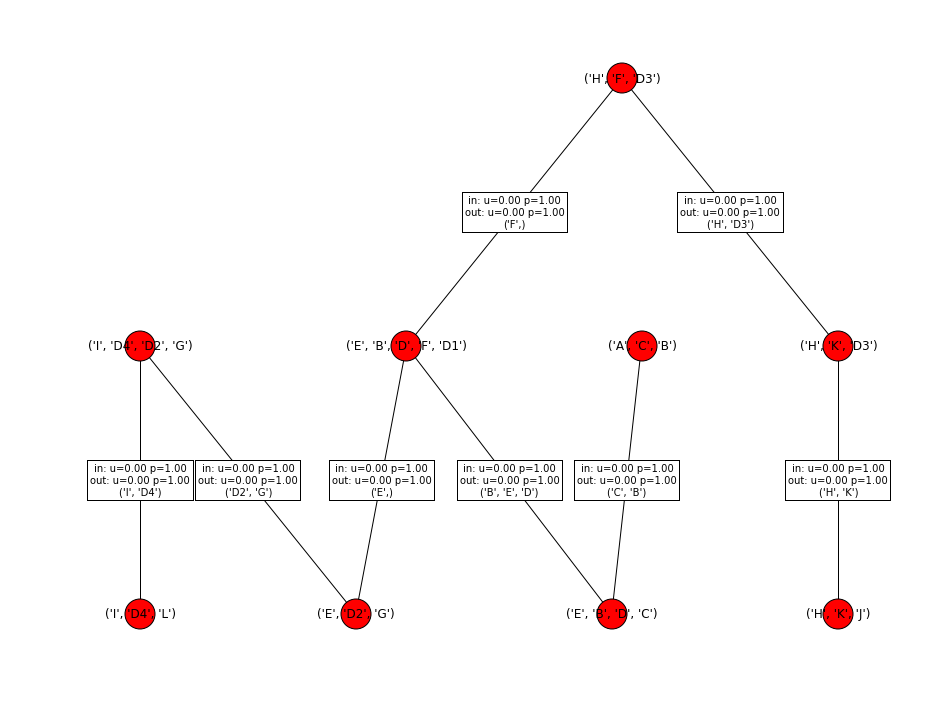

In [20]:
junction_tree = to_junctiontree(triangulated)
draw_graph(junction_tree)

In [50]:
cliques = [tuple(c) for c in nx.find_cliques(triangulated)]
cliques
windows = {0: ['B'], 
           1: ['D1'],
           2: ['F', 'E'],
           3: ['D2'],
           4: [],
           5: ['D3'],
           6: ['G'],
           7: ['D4'],
           8: ['D', 'C', 'H', 'K', 'J', 'I', 'L', 'A']}
windows

{0: ['B'],
 1: ['D1'],
 2: ['F', 'E'],
 3: ['D2'],
 4: [],
 5: ['D3'],
 6: ['G'],
 7: ['D4'],
 8: ['D', 'C', 'H', 'K', 'J', 'I', 'L', 'A']}

In [66]:
def get_cliques(ugraph, verbose=False):
    u = ugraph.copy()
    cliques = []
    separators = []
    variables = []
    i = [0]
    remaining_nodes = []
    elim_order = []
    for n, w in sorted(windows.items()):
        remaining_nodes.extend(w)
    #remaining = ['E','D','C','B','G','J','H','I','F','A']
    #print remaining
    
    # i = 0
    while remaining_nodes:
        proposed_clique = []
        eliminate = []
        separator = []
        
        selected = remaining_nodes[-1]
        family = fa(u,selected)
        proposed_clique.extend(family)
        eliminate.append(selected)
        #family.remove(selected)
        print 'Selected: ', selected
        #print 'Family: ',family
        for f in family:
            if f is selected:
                remaining_nodes.remove(f)
            elif set(nb(u, f)) <= set(family):
                #print 'Eliminating ',f
                remaining_nodes.remove(f)
                eliminate.append(f)
            else:
                #print 'f: ',f
                #print f, set(nb(u,f))
                separator.append(f)
        i.append(i[-1] + len(eliminate))
        if verbose:
            print 'Clique: ',proposed_clique
            print 'V: ', eliminate
            print 'S: ', separator
            print 'i: ', i[-1]
            print

        u.remove_nodes_from(eliminate)
        cliques.append(proposed_clique)
        separators.append(separator)
        variables.append(eliminate)

    i.remove(0)
    return cliques, separators, variables, i
    
                     
get_cliques(triangulated, True)

Selected:  A
Clique:  ['A', 'C', 'B']
V:  ['A']
S:  ['C', 'B']
i:  1

Selected:  L
Clique:  ['L', 'I', 'D4']
V:  ['L']
S:  ['I', 'D4']
i:  2

Selected:  I
Clique:  ['I', 'D4', 'D2', 'G']
V:  ['I', 'D4']
S:  ['D2', 'G']
i:  4

Selected:  J
Clique:  ['J', 'H', 'K']
V:  ['J']
S:  ['H', 'K']
i:  5

Selected:  K
Clique:  ['K', 'H', 'D3']
V:  ['K']
S:  ['H', 'D3']
i:  6

Selected:  H
Clique:  ['H', 'D3', 'F']
V:  ['H', 'D3']
S:  ['F']
i:  8

Selected:  C
Clique:  ['C', 'B', 'E', 'D']
V:  ['C']
S:  ['B', 'E', 'D']
i:  9

Selected:  D
Clique:  ['D', 'B', 'E', 'D1', 'F']
V:  ['D', 'B', 'D1', 'F']
S:  ['E']
i:  13

Selected:  G
Clique:  ['G', 'D2', 'E']
V:  ['G', 'D2', 'E']
S:  []
i:  16



([['A', 'C', 'B'],
  ['L', 'I', 'D4'],
  ['I', 'D4', 'D2', 'G'],
  ['J', 'H', 'K'],
  ['K', 'H', 'D3'],
  ['H', 'D3', 'F'],
  ['C', 'B', 'E', 'D'],
  ['D', 'B', 'E', 'D1', 'F'],
  ['G', 'D2', 'E']],
 [['C', 'B'],
  ['I', 'D4'],
  ['D2', 'G'],
  ['H', 'K'],
  ['H', 'D3'],
  ['F'],
  ['B', 'E', 'D'],
  ['E'],
  []],
 [['A'],
  ['L'],
  ['I', 'D4'],
  ['J'],
  ['K'],
  ['H', 'D3'],
  ['C'],
  ['D', 'B', 'D1', 'F'],
  ['G', 'D2', 'E']],
 [1, 2, 4, 5, 6, 8, 9, 13, 16])

In [49]:
def find_root(ugraph):
    roots = []
    w = windows.get(0)
    for n in w:
        family = fa(ugraph, n)
        print family
        
find_root(triangulated)

['B', 'A', 'C', 'E', 'D', 'F', 'D1']


## Probability Propagation